In [30]:
import sys
import os

import pandas as pd
import numpy as np

from string import ascii_uppercase


import rasterio as rio

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import metrics

import glob
import tqdm

from subprocess import Popen

%matplotlib inline

# Vegetation Mask Comparisions

In [61]:
root = "/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/ASO_3M_SD_USCATE_20180528/"

In [62]:
vegmask = os.path.join(root, "veg/USCATB20140827_CHM_1m_thresh_4326.tif")

In [63]:
image_ids = open(os.path.join(root, "selected_images_rework.txt")).read().strip().split('\n')

In [64]:
image_ids

['181108', '181109', '181110', '181111', '181112', '181113']

## Clip veg to individual images

In [48]:
gdal_clip = "gdalwarp -dstnodata 9999 -cutline {cutline} -crop_to_cutline {vegmask} {vegmask_clipped}"
for image_id in image_ids:
    image_root = glob.glob(os.path.join(root, f"*{image_id}*"))[0]
    gdal_clip_cmd = gdal_clip.format(
        cutline = os.path.join(image_root, 'data-mask.geojson'),
        vegmask = vegmask,
        vegmask_clipped = os.path.join(image_root, 'veg_mask_clipped.vrt')
    )
    Popen(gdal_clip_cmd, shell=True).communicate()


## Resample + Clip all Metrics in all Images

In [55]:
gdal_combine = "gdalbuildvrt -overwrite -resolution lowest " \
               "-separate -r {resampling} -vrtnodata '-9999 -9999 -9999' " \
               "{output}.vrt {comparator} {aso} {veg}"
        

In [65]:
all_results = []
aso_glob = "*/ASO_merged.tif"
comparators_glob = [
    ('ml', "*/*SR_clip_merged.tif"),
    ('s2', "*/*NDSI*.tif"),
    ('ls8', "*/LC08*.tif")
]

In [67]:
# for each image, need to build {pred, aso, pred} file at coarsest resolution.

for image_id in tqdm.tqdm(image_ids):
    image_root = glob.glob(os.path.join(root, f"*{image_id}*"))[0]
    os.makedirs(os.path.join(root, image_root, "veg"), exist_ok=True)
    aso = glob.glob(os.path.join(root, image_root, aso_glob))[0]
    for kind, comparator in comparators_glob:
        raw_comparator = glob.glob(os.path.join(root, image_root, comparator))[0]
        outfile =  os.path.join(root, image_root, "veg", f"{kind}_aso_veg")
        combine_command = gdal_combine.format(
            resampling = 'nearest',
            output = outfile, 
            aso = aso, 
            comparator = raw_comparator, 
            veg = os.path.join(root, image_root, "veg_mask_clipped.vrt")
        )
        Popen(combine_command, shell=True).communicate()
        
        comparator_combined = rio.open(outfile+'.vrt')
        _comparator_data = comparator_combined.read(1, masked=True)
        _aso_data = comparator_combined.read(2, masked=True)
        _vegmask_data = comparator_combined.read(3, masked=True)
        
        ## Comparator Veg + NoVeg (+nodata) Masking
        comp_nodata = rio.open(raw_comparator).nodata
        comp_veg_on_nodata_mask = (
            (_vegmask_data.data == 0) |
            (_aso_data.mask) |
            (_comparator_data.data == comp_nodata)
        ).astype(bool)
        comp_veg = _comparator_data.copy()
        comp_veg.mask = comp_veg_on_nodata_mask
        comp_veg_off_nodata_mask = (
            (_vegmask_data.data == 1) | 
            (_aso_data.mask) | 
            (_comparator_data.data == comp_nodata)
        ).astype(bool)
        comp_noveg = _comparator_data.copy()
        comp_noveg.mask = comp_veg_off_nodata_mask
        
        ## ASO Veg + NoVeg (+nodata) Masking (For reference; coarsened.)
        aso_veg_on_nodata_mask = (
            (_vegmask_data.data == 0) | 
            (_aso_data.mask) | 
            (_comparator_data.data == comp_nodata)
        ).astype(bool)
        aso_veg = _aso_data.copy()
        aso_veg.mask = aso_veg_on_nodata_mask
        aso_veg_off_nodata_mask = (
            (_vegmask_data.data == 1) | 
            (_aso_data.mask) | 
            (_comparator_data.data == comp_nodata)
        ).astype(bool)
        aso_noveg = _aso_data.copy()
        aso_noveg.mask = aso_veg_off_nodata_mask
    

        
        
        ## comparison
        true_veg, comp_veg = aso_veg[~aso_veg.mask].data, comp_veg[~comp_veg.mask].data
        performance_veg = metrics.precision_recall_fscore_support(true_veg, comp_veg, average='binary')
        accuracy_veg = metrics.balanced_accuracy_score(true_veg, comp_veg)
        
        true_noveg, comp_noveg = aso_noveg[~aso_noveg.mask].data, comp_noveg[~comp_noveg.mask].data
        performance_noveg = metrics.precision_recall_fscore_support(true_noveg, comp_noveg, average='binary')
        accuracy_noveg = metrics.balanced_accuracy_score(true_noveg, comp_noveg)
        
        
        
        ## combine for comparator
        combined_veg = pd.DataFrame.from_records(
            [list(performance_veg[:3]) + [accuracy_veg]], 
            columns = ['Precision', 'Recall', 'F-Score', 'Balanced Accuracy']
        ).assign(type='Vegetation Only')
        combined_noveg = pd.DataFrame.from_records(
            [list(performance_noveg[:3]) + [accuracy_noveg]], 
            columns = ['Precision', 'Recall', 'F-Score', 'Balanced Accuracy']
        ).assign(type='No Vegetation')
        
        combined = pd.melt(
            pd.concat([combined_veg, combined_noveg]),
            id_vars = 'type', 
            value_vars = ['Precision', 'Recall', 'F-Score', 'Balanced Accuracy']
        ).assign(comparator=kind, image_id = image_id)
        
        all_results.append(combined)
        

        
        
        
    
        
        

100%|██████████| 6/6 [04:35<00:00, 45.87s/it]


In [68]:
all_results_df = pd.concat(all_results)

In [69]:
all_results_df

,type,variable,value,comparator,image_id
0,Vegetation Only,Precision,0.363777,ml,181108
1,No Vegetation,Precision,0.365132,ml,181108
2,Vegetation Only,Recall,0.951001,ml,181108
3,No Vegetation,Recall,0.951138,ml,181108
4,Vegetation Only,F-Score,0.526252,ml,181108
...,...,...,...,...,...
3,No Vegetation,Recall,0.723059,ls8,181113
4,Vegetation Only,F-Score,0.664331,ls8,181113
5,No Vegetation,F-Score,0.734694,ls8,181113
6,Vegetation Only,Balanced Accuracy,0.848177,ls8,181113


(0, 1)

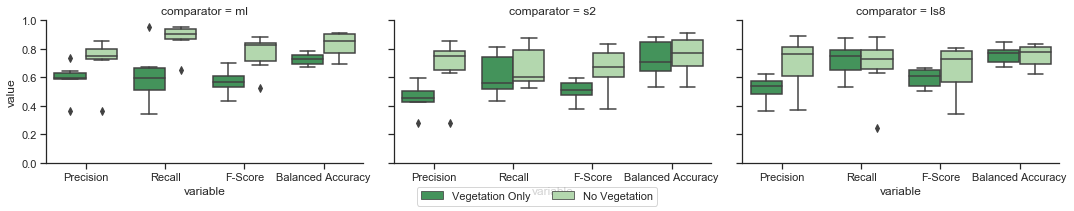

In [70]:
sns.set(style='ticks')
# plt.rc('text', usetex=True)


retval = sns.catplot(x='variable', y='value', hue='type', kind='box', col='comparator', data=all_results_df, hue_order=['Vegetation Only', "No Vegetation"], palette='Greens_r', dodge=True, height=3, aspect=1.5)
sns.despine()
h,l = retval.axes[0][0].get_legend_handles_labels()
retval._legend.remove()
retval.fig.legend(h,l, ncol=2, loc='lower center') # you can specify any location parameter you want here
# plt.savefig("comparator_veg.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
# retval.fig.add_axes([0, 0, 0.2, 0.2])
plt.ylim([0, 1])

In [71]:
all_results_df = all_results_df.replace({
    'ls8' : "Landsat 8 fSCA", 
    's2' : "Sentinel-2 NDSI", 
    'ml' : "CubeSat ML"
}).rename({
    'comparator' : "SCA"
}, axis=1)

In [72]:
colors = [
    "tab:green", # veg,
    "tab:brown",
    "tab:orange"
    #     'grey'#     cm.Greens(0.3), # veg,

]
cmap = sns.color_palette(colors)

In [73]:
resolutions = {
    "CubeSat ML" : "3 m",
    "Sentinel-2 NDSI": "10 m",
    "Landsat 8 fSCA": "30 m"
}

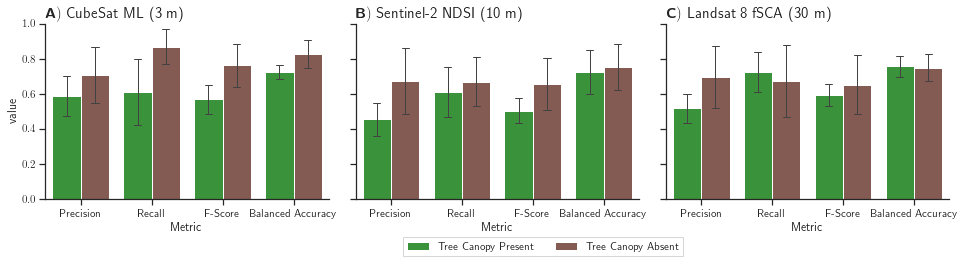

In [95]:
import matplotlib 
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plot = sns.catplot(x='variable', y='value', hue='type', kind='bar', ci='sd', col='SCA', data=all_results_df,
                     col_order=["CubeSat ML", "Sentinel-2 NDSI", "Landsat 8 fSCA"], 
                     hue_order=['Vegetation Only', "No Vegetation"],
                     palette=cmap, 
                     height=3, aspect=1.5, capsize=0.1, errwidth=1)

[ax.set_xlabel("Metric") for ax in list(plot.axes)[0]]
plot.set(ylim=[0, 1])
h,l = plot.axes[0][0].get_legend_handles_labels()
l = [
    r"Tree Canopy Present",
    r"Tree Canopy Absent",
]
plot._legend.remove()
plot.fig.legend(h,l, ncol=3, loc='center', bbox_to_anchor=(0.5,0.05), frameon=True, fancybox=False) # you can specify any location parameter you want here

# plot.set_titles(template='')
for i, ax in enumerate(plot.axes[0]):
    title = ax.get_title().split(" = ")[1]
    ax.set_title(r"$\textbf{" + ascii_uppercase[i] + r"})$ " + f"{title} (" + resolutions[title] + ")", loc='left', fontsize=15)
plot.set_titles(template='')



plot.fig.set_figheight(plot.fig.bbox_inches.bounds[3] + 0.7)
# plt.tight_layout()
plt.savefig("comparator_veg_all.png", dpi=300, bbox_inches='tight', )



In [75]:
all_results_df.to_csv("veg_comparison.csv")

## Assess vegetation percentage

In [52]:
percentages = []
for image_id in tqdm.tqdm(image_ids):
    image_root = glob.glob(os.path.join(root, f"*{image_id}*"))[0]
    raw_comparator = os.path.join(image_root, "veg", "ml_aso_veg.vrt")
    comparator_combined = rio.open(raw_comparator)
    _comparator_data = comparator_combined.read(1, masked=True)
    _aso_data = comparator_combined.read(2, masked=True)
    _vegmask_data = comparator_combined.read(3, masked=True)
    
    _, (nd, noveg_count, veg_count) = np.unique(_vegmask_data.data, return_counts=True)
    percentages.append(veg_count / (noveg_count + veg_count))


100%|██████████| 6/6 [01:24<00:00, 14.05s/it]


In [53]:
percentages

[0.2597772597772598,
 0.23606052437003025,
 0.24862637684644187,
 0.36448985396210215,
 0.5116526813458994,
 0.5500308077526872]

That last image-id seems to have the most even percentage, so we'll convert the plots to use that image. 

In [2]:
import matplotlib 
import seaborn as sns
matplotlib.rc('text', usetex=True)

matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
sns.set(font_scale=2)
plot = sns.catplot(x='variable', y='value', hue='type', kind='bar', col='SCA', data=all_results_df[all_results_df.image_id == image_ids[-1]],
                     col_order=["CubeSat ML", "Sentinel-2 NDSI", "Landsat 8 fSCA"], 
                     hue_order=['Vegetation Only', "No Vegetation"],
                     palette=cmap, 
                     height=3, aspect=1.5)#, capsize=0.1, errwidth=1)

[ax.set_xlabel("Metric") for ax in list(plot.axes)[0]]
plot.set(ylim=[0, 1])
h,l = plot.axes[0][0].get_legend_handles_labels()
l = [
    r"Tree Canopy Present",
    r"Tree Canopy Absent",
]
plot._legend.remove()
plot.fig.legend(h,l, ncol=3, loc='center', bbox_to_anchor=(0.5,0.05), frameon=True, fancybox=False) # you can specify any location parameter you want here

# plot.set_titles(template='')
for i, ax in enumerate(plot.axes[0]):
    title = ax.get_title().split(" = ")[1]
    ax.set_title(r"$\textbf{" + ascii_uppercase[i] + r"})$ " + f"{title} (" + resolutions[title] + ")", loc='left', fontsize=15)
plot.set_titles(template='')



plot.fig.set_figheight(plot.fig.bbox_inches.bounds[3] + 0.7)
# plt.tight_layout()
plt.savefig("comparator_veg_all.png", dpi=300, bbox_inches='tight', )
plt.suptitle(f"imageid = {image_ids[-1]}")


NameError: name 'all_results_df' is not defined

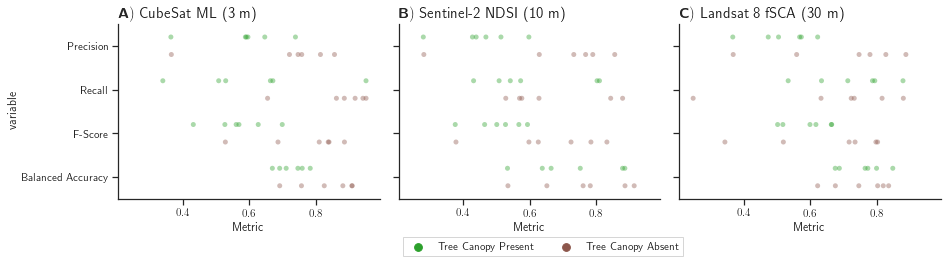

In [91]:
import matplotlib 
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plot = sns.catplot(y='variable', x='value', hue='type', kind='strip', col='SCA', data=all_results_df,
                     col_order=["CubeSat ML", "Sentinel-2 NDSI", "Landsat 8 fSCA"], 
                     hue_order=['Vegetation Only', "No Vegetation"],
                     palette=cmap, jitter=0, dodge=0.2, alpha=0.4,
                     height=3, aspect=1.5)#, capsize=0.1, errwidth=1)

[ax.set_xlabel("Metric") for ax in list(plot.axes)[0]]
h,l = plot.axes[0][0].get_legend_handles_labels()
l = [
    r"Tree Canopy Present",
    r"Tree Canopy Absent",
]
plot._legend.remove()
plot.fig.legend(h,l, ncol=3, loc='center', bbox_to_anchor=(0.5,0.05), frameon=True, fancybox=False) # you can specify any location parameter you want here

# plot.set_titles(template='')
for i, ax in enumerate(plot.axes[0]):
    title = ax.get_title().split(" = ")[1]
    ax.set_title(r"$\textbf{" + ascii_uppercase[i] + r"})$ " + f"{title} (" + resolutions[title] + ")", loc='left', fontsize=15)
plot.set_titles(template='')



plot.fig.set_figheight(plot.fig.bbox_inches.bounds[3] + 0.7)
# plt.tight_layout()
plt.savefig("comparator_veg_all.png", dpi=300, bbox_inches='tight', )

